In [1]:
%matplotlib inline

#Import Dependencies

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report, precision_recall_curve, roc_auc_score, roc_curve, auc, precision_recall_fscore_support
import itertools
from scipy import interp
from itertools import cycle
import scikitplot as skplt
import shutil

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

from tensorflow import set_random_seed
set_random_seed(101)

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Using TensorFlow backend.


In [2]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [3]:
base_meta_file = os.path.join('resources')
image_files = os.path.join('images')

In [4]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

In [5]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(image_files, '*.jpg'))}

In [6]:
#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

In [7]:
# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

In [8]:
# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

# Create directories for later 2 category merge
ben = os.path.join(train_dir, 'ben')
os.mkdir(ben)
mal = os.path.join(train_dir, 'mal')
os.mkdir(mal)

# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

# Create directories for later 2 category merge

ben = os.path.join(val_dir, 'ben')
os.mkdir(ben)
mal = os.path.join(val_dir, 'mal')
os.mkdir(mal)

In [9]:
#base_skin_dir = os.path.join('..', 'input')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

#imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
#                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

#print(len(imageid_path_dict))

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [10]:
# Create dataframe to hold metadata
df_data = pd.read_csv(os.path.join(base_meta_file, 'HAM10000_metadata.csv'))

In [11]:
# Filter for lesion_id's that only have one image

# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [12]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [13]:
# Check for duplicate totals
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [14]:
# filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [15]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 8)

In [16]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [17]:
df_train['dx'].value_counts()

nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: dx, dtype: int64

In [18]:
df_data["image_id_stepwise"] = df_data["image_id"]

In [19]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [20]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('images')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('images', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('images', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [21]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/mal')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

0
1074
1024
484
301
131
109


In [22]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


In [24]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)

    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)

    # Generate the augmented images and add them to the training folders
    ###########
    num_aug_images_wanted = 2000 # total number of images we want to have in each class
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 2000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 2024 images belonging to 1 classes.
Found 2024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [25]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
2024
2024
1986
1805
1803
1517


In [26]:
# Check how many val images we have in each folder.
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


In [ ]:
#benign_train_nv = os.listdir('base_dir/train_dir/nv')
#benign_train_nv.head()

#ben = os.path.join(train_dir, 'ben')
#os.mkdir(ben)
#mal = os.path.join(train_dir, 'mal')
#os.mkdir(mal)

In [49]:
# Merge benign-type train and validation images into ben folders

# Criteria used for binary classification:
# 'mel' == 1 (malignant)
# 'bcc' == 1 (malignant)
# 'akiec' == 1 (malignant)
# 'nv' == 1 (benign)
# 'bkl' == 1 (benign)
# 'vasc' == 1 (benign)
# 'df' == 1 (benign)

#ben_train = os.listdir('base_dir/train_dir/ben')
#mal_train = os.listdir('base_dir/train_dir/mal')

#ben_val = os.listdir('base_dir/val_dir/ben')
#mal_val = os.listdir('base_dir/val_dir/mal')
#ben_train

In [36]:
# Get a list of benign train and val images
#benign_train_nv = os.listdir('base_dir/train_dir/nv')
#benign_train_bkl = os.listdir('base_dir/train_dir/bkl')
#benign_train_vasc = os.listdir('base_dir/train_dir/vasc')
#benign_train_df = os.listdir('base_dir/train_dir/df')

# Criteria used for binary classification:
# 'mel' == 1 (malignant)
# 'bcc' == 1 (malignant)
# 'akiec' == 1 (malignant)
# 'nv' == 1 (benign)
# 'bkl' == 1 (benign)
# 'vasc' == 1 (benign)
# 'df' == 1 (benign)

In [51]:
# Copy all files from training and validation directories into binary classes
#  ben = benign, represented later by 0's, 
#  mal = malignant, represented later by 1's

# Move augmented benign train files

src = 'base_dir/train_dir/nv'
dest = 'base_dir/train_dir/ben'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if (os.path.isfile(full_file_name)):
        shutil.copy(full_file_name, dest)
        
src = 'base_dir/train_dir/bkl'
dest = 'base_dir/train_dir/ben'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if (os.path.isfile(full_file_name)):
        shutil.copy(full_file_name, dest)

src = 'base_dir/train_dir/vasc'
dest = 'base_dir/train_dir/ben'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if (os.path.isfile(full_file_name)):
        shutil.copy(full_file_name, dest)

src = 'base_dir/train_dir/df'
dest = 'base_dir/train_dir/ben'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if (os.path.isfile(full_file_name)):
        shutil.copy(full_file_name, dest)
        
# Move augmented malignant train files

src = 'base_dir/train_dir/mel'
dest = 'base_dir/train_dir/mal'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if (os.path.isfile(full_file_name)):
        shutil.copy(full_file_name, dest)

src = 'base_dir/train_dir/bcc'
dest = 'base_dir/train_dir/mal'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if (os.path.isfile(full_file_name)):
        shutil.copy(full_file_name, dest)

src = 'base_dir/train_dir/akiec'
dest = 'base_dir/train_dir/mal'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if (os.path.isfile(full_file_name)):
        shutil.copy(full_file_name, dest)
        
# Move augmented malignant validation files

src = 'base_dir/val_dir/nv'
dest = 'base_dir/val_dir/ben'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if (os.path.isfile(full_file_name)):
        shutil.copy(full_file_name, dest)
        
src = 'base_dir/val_dir/bkl'
dest = 'base_dir/val_dir/ben'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if (os.path.isfile(full_file_name)):
        shutil.copy(full_file_name, dest)

src = 'base_dir/val_dir/vasc'
dest = 'base_dir/val_dir/ben'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if (os.path.isfile(full_file_name)):
        shutil.copy(full_file_name, dest)

src = 'base_dir/val_dir/df'
dest = 'base_dir/val_dir/ben'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if (os.path.isfile(full_file_name)):
        shutil.copy(full_file_name, dest)
        
# Move augmented malignant validation files

src = 'base_dir/val_dir/mel'
dest = 'base_dir/val_dir/mal'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if (os.path.isfile(full_file_name)):
        shutil.copy(full_file_name, dest)

src = 'base_dir/val_dir/bcc'
dest = 'base_dir/val_dir/mal'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if (os.path.isfile(full_file_name)):
        shutil.copy(full_file_name, dest)

src = 'base_dir/val_dir/akiec'
dest = 'base_dir/val_dir/mal'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if (os.path.isfile(full_file_name)):
        shutil.copy(full_file_name, dest)

In [71]:
# Remove the old augmentation directories

shutil.rmtree('base_dir/train_dir/akiec')
shutil.rmtree('base_dir/train_dir/bcc')
shutil.rmtree('base_dir/train_dir/bkl')
shutil.rmtree('base_dir/train_dir/df')
shutil.rmtree('base_dir/train_dir/mel')
shutil.rmtree('base_dir/train_dir/nv')
shutil.rmtree('base_dir/train_dir/vasc')

shutil.rmtree('base_dir/val_dir/akiec')
shutil.rmtree('base_dir/val_dir/bcc')
shutil.rmtree('base_dir/val_dir/bkl')
shutil.rmtree('base_dir/val_dir/df')
shutil.rmtree('base_dir/val_dir/mel')
shutil.rmtree('base_dir/val_dir/nv')
shutil.rmtree('base_dir/val_dir/vasc')

In [72]:
df_data.head()

,lesion_id,dx,dx_type,age,sex,localization,duplicates,train_or_val,image_id_stepwise,path,cell_type,malignant_benign,cell_type_idx
image_id,,,,,,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,has_duplicates,train,ISIC_0027419,images\ISIC_0027419.jpg,Benign keratosis-like lesions,0,2
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,has_duplicates,train,ISIC_0025030,images\ISIC_0025030.jpg,Benign keratosis-like lesions,0,2
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,has_duplicates,train,ISIC_0026769,images\ISIC_0026769.jpg,Benign keratosis-like lesions,0,2
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,has_duplicates,train,ISIC_0025661,images\ISIC_0025661.jpg,Benign keratosis-like lesions,0,2
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,has_duplicates,train,ISIC_0031633,images\ISIC_0031633.jpg,Benign keratosis-like lesions,0,2


In [74]:
# Now lets see the sample of tile_df to look on newly made columns
#df_data.head()

,lesion_id,dx,dx_type,age,sex,localization,duplicates,train_or_val,image_id_stepwise,path,cell_type,malignant_benign,cell_type_idx
image_id,,,,,,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,has_duplicates,train,ISIC_0027419,images\ISIC_0027419.jpg,Benign keratosis-like lesions,0,2
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,has_duplicates,train,ISIC_0025030,images\ISIC_0025030.jpg,Benign keratosis-like lesions,0,2
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,has_duplicates,train,ISIC_0026769,images\ISIC_0026769.jpg,Benign keratosis-like lesions,0,2
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,has_duplicates,train,ISIC_0025661,images\ISIC_0025661.jpg,Benign keratosis-like lesions,0,2
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,has_duplicates,train,ISIC_0031633,images\ISIC_0031633.jpg,Benign keratosis-like lesions,0,2


In [75]:
#df_data.isnull().sum()

lesion_id            0
dx                   0
dx_type              0
age                  0
sex                  0
localization         0
duplicates           0
train_or_val         0
image_id_stepwise    0
path                 0
cell_type            0
malignant_benign     0
cell_type_idx        0
dtype: int64

In [76]:
#df_data['age'].fillna((df_data['age'].mean()), inplace=True)

In [77]:
#df_data.isnull().sum()

lesion_id            0
dx                   0
dx_type              0
age                  0
sex                  0
localization         0
duplicates           0
train_or_val         0
image_id_stepwise    0
path                 0
cell_type            0
malignant_benign     0
cell_type_idx        0
dtype: int64

In [78]:
#print(df_data.dtypes)

lesion_id             object
dx                    object
dx_type               object
age                  float64
sex                   object
localization          object
duplicates            object
train_or_val          object
image_id_stepwise     object
path                  object
cell_type             object
malignant_benign       int64
cell_type_idx           int8
dtype: object


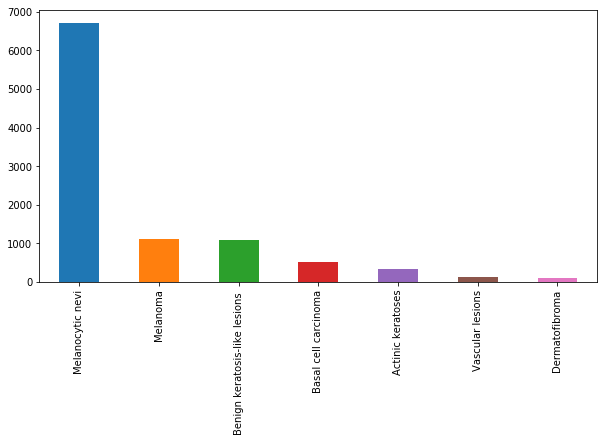

In [79]:
#fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
#df_data['cell_type'].value_counts().plot(kind='bar', ax=ax1)

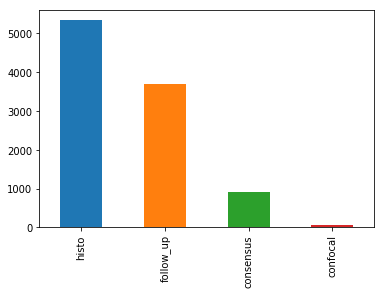

In [80]:
#df_data['dx_type'].value_counts().plot(kind='bar')

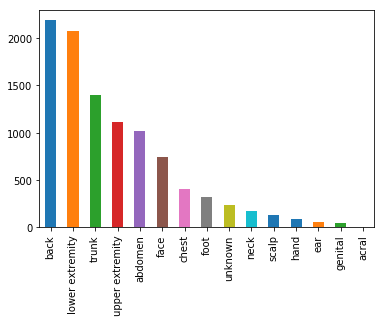

In [81]:
#df_data['localization'].value_counts().plot(kind='bar')

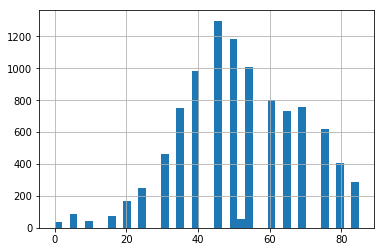

In [82]:
df_data['age'].hist(bins=40)

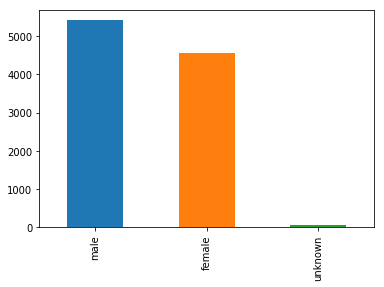

In [83]:
df_data['sex'].value_counts().plot(kind='bar')

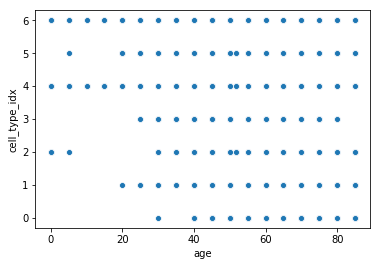

In [84]:
sns.scatterplot('age','cell_type_idx',data=df_data)

C:\Users\james\Anaconda3\envs\PythonData\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\james\Anaconda3\envs\PythonData\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


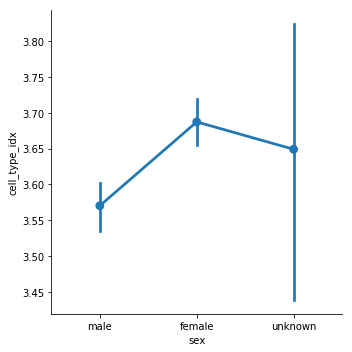

In [85]:
#sns.factorplot('sex','cell_type_idx',data=df_data)

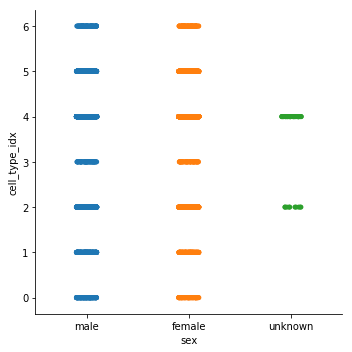

In [86]:
#sns.catplot('sex','cell_type_idx',data=df_data)

In [87]:
#df_train.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates,train_or_val
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates,train


In [88]:
# Setup model-related variables

train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 20
val_batch_size = 20
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [89]:
# More model setup

datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 17113 images belonging to 2 classes.
Found 938 images belonging to 2 classes.
Found 938 images belonging to 2 classes.


In [90]:
# create a copy of a mobilenet model

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [91]:
# Model Summary
#mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [93]:
# How many layers does MobileNet have?
len(mobile.layers)

93

In [94]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 2 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(2, activation='sigmoid')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [95]:
# Updated model summary
#model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [96]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [98]:
model.compile(Adam(lr=0.01), loss='binary_crossentropy', 
              metrics=['binary_accuracy'])

In [99]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'ben': 0, 'mal': 1}


In [100]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # ben
    1: 2.0, # mal #Try to make the model more sensitive to malignant
}

In [101]:
# Set up final model variables

filepath = "model_binary.h5"
checkpoint = ModelCheckpoint(filepath, monitor='binary_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='binary_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=2, verbose=1,
                   callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
856/856 [==============================] - 2395s 3s/step - loss: 0.5078 - binary_accuracy: 0.7576 - val_loss: 0.2631 - val_binary_accuracy: 0.9099
Epoch 2/2
112/856 [==>...........................] - ETA: 32:23 - loss: 0.3951 - binary_accuracy: 0.8103

KeyboardInterrupt: 

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

In [ ]:
# Here the the last epoch will be used.

val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

In [ ]:
# Here the best epoch will be used.

model.load_weights('lesion_model_binary.h5')

val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

plt.show()

In [ ]:
# Get the labels of the test images.
test_labels = test_batches.classes

In [ ]:
# Print the label associated with each class
test_batches.class_indices

In [ ]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

In [ ]:
predictions.shape

In [ ]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, test_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(test_labels))
    plt.xticks(tick_marks, test_labels, rotation=45)
    plt.yticks(tick_marks, test_labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
test_labels.shape

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_batches.class_indices

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['ben', 'mal']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

In [ ]:
cohen_kappa_score(y_true, y_pred)

In [ ]:
roc_auc = roc_auc_score(y_true, y_pred) 
roc_auc

In [ ]:
fpr, tpr, _ = roc_curve(y_true,  y_pred)
auc = roc_auc_score(y_true, y_pred)
plt.plot(fpr,tpr,label="Predictor, auc="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('True Negative Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
## No need to print sample images at this time

#n_samples = 5
#fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
#for n_axs, (type_name, type_rows) in zip(m_axs, 
#                                         df_data.sort_values(['cell_type']).groupby('cell_type')):
#    n_axs[0].set_title(type_name)
#    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
#        c_ax.imshow(c_row['image'])
#        c_ax.axis('off')
#fig.savefig('category_samples.png', dpi=300)

In [ ]:
# To clear model input if needed
#model = None

In [ ]:
# Define the optimizer
#optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
#precision_recall_fscore_support(Y_true, Y_pred_classes)